# XGBoost

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

2022-11-09 21:29:06.392033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 21:29:06.571835: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 21:29:07.442508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


['/device:CPU:0', '/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7']


2022-11-09 21:29:08.418521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 21:29:13.330872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 31622 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-11-09 21:29:13.332958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 33659 MB memory:  -> device: 1, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2022-11-09 21:29:13.334704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:2 with 33659 MB memory:  -> device: 2, name: A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capab

In [3]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'

In [4]:
import pandas as pd
import numpy as np
# import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import joblib
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score 
from sklearn.feature_selection import RFECV
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [5]:
%cd ..

/workspace/asurion_f22_jw


In [6]:
strain = pd.read_csv('fe_data_v2/sentiment_train.csv', index_col='id')
stest = pd.read_csv('fe_data_v2/sentiment_test.csv', index_col='id')
test = pd.read_csv('fe_data_v2/sale_data/test_sale_encoded.csv', index_col='id')
train = pd.read_csv('fe_data_v2/sale_data/train_sale_encoded.csv', index_col='id')

In [7]:
display(train.shape)
display(test.shape)

(953112, 42)

(258459, 42)

In [8]:
train = train.join(strain)
test = test.join(stest)

In [9]:
display(train.sentiment.isnull().sum()/len(train))
display(test.sentiment.isnull().sum()/len(test))

0.1788467672214808

0.35070165867700487

In [10]:
test.columns

Index(['quality_sale', 'accepted_flg', 'clndr_dt_cst', 'start_dt', 'lines',
       'previous_tech_support_call', 'account_tenure', 'past_yr_claim_count',
       'num_decline', 'exp', 'product_type', 'pmake', 'claritas_hh_count',
       'technodoption_class', 'hh_income', 'age_class', 'hh_education',
       'hh_composition', 'hh_tenure', 'urbanicity', 'median_income',
       'total_population', 'perc_female', 'perc_under18', 'perc_over65',
       'perc_white', 'perc_black', 'population_density', 'zipcode', 'county',
       'state', 'state_code', 'latitude', 'longitude', 'month',
       'hh_income_code', 'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [11]:
dcols = ['quality_sale', 'clndr_dt_cst', 'start_dt', 'zipcode', 'county', 'state', 
         'state_code', 'latitude', 'longitude', 'hh_income_code', 'month']

In [12]:
test.drop(columns = dcols, inplace = True)
test = test[(test['zipcode_accepted_prop'].isnull()==False)& (test['zipcode_rejected_offers'].isnull()==False)& 
            (test['zipcode_accepted_offers'].isnull()==False)&(test['zipcode_total_offers'].isnull()==False)&
            (test['sentiment'].isnull()==False)]

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144064 entries, 0000fd2c36b4cd8dd7028dec2e31b26dc19ca0bb8c569ffca4dd81af to ffff52db3fd282e569f7613b6e58ee934a3952ccbd0cf460dec2a7ec
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   accepted_flg                144064 non-null  int64  
 1   lines                       144064 non-null  int64  
 2   previous_tech_support_call  144064 non-null  int64  
 3   account_tenure              144064 non-null  int64  
 4   past_yr_claim_count         144064 non-null  int64  
 5   num_decline                 144064 non-null  int64  
 6   exp                         144064 non-null  int64  
 7   product_type                144064 non-null  object 
 8   pmake                       144064 non-null  object 
 9   claritas_hh_count           144064 non-null  int64  
 10  technodoption_class         144064 non-null  object 
 11  hh_income                   14

In [14]:
# test.to_csv('fe_data_v2/sale_data/testing.csv')

In [15]:
train.drop(columns = dcols, inplace = True)
train = train[(train['zipcode_accepted_prop'].isnull()==False)& (train['zipcode_rejected_offers'].isnull()==False)& 
            (train['zipcode_accepted_offers'].isnull()==False)&(train['zipcode_total_offers'].isnull()==False)&
             (train['sentiment'].isnull()==False)]

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 708693 entries, 00000ae713f5fb239145480134305b42d3e3355c17fbeeb391532578 to fffff1fb82ff281caddfb033a179d89bc109ad5b36511002157beb3f
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   accepted_flg                708693 non-null  int64  
 1   lines                       708693 non-null  int64  
 2   previous_tech_support_call  708693 non-null  int64  
 3   account_tenure              708693 non-null  int64  
 4   past_yr_claim_count         708693 non-null  int64  
 5   num_decline                 708693 non-null  int64  
 6   exp                         708693 non-null  int64  
 7   product_type                708693 non-null  object 
 8   pmake                       708693 non-null  object 
 9   claritas_hh_count           708693 non-null  int64  
 10  technodoption_class         708693 non-null  object 
 11  hh_income                   70

In [17]:
# train.to_csv('fe_data_v2/sale_data/training.csv')

In [18]:
train.shape

(708693, 32)

In [19]:
num_list = ['lines', 'previous_tech_support_call', 'account_tenure', 'past_yr_claim_count', 'num_decline', 
            'claritas_hh_count', 'median_income', 'total_population', 'perc_female', 'perc_under18',
            'perc_over65', 'perc_white', 'perc_black', 'population_density',
            'zipcode_accepted_prop', 'zipcode_rejected_offers', 'zipcode_accepted_offers', 'zipcode_total_offers']
cat_list = ['exp', 'product_type', 'pmake', 'technodoption_class', 'hh_income', 'age_class', 'hh_education', 
            'hh_composition', 'hh_tenure', 'urbanicity', 'day_of_week', 'time_of_day', 'sentiment']
len(num_list+cat_list)

31

In [20]:
train.columns

Index(['accepted_flg', 'lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [21]:
test.columns

Index(['accepted_flg', 'lines', 'previous_tech_support_call', 'account_tenure',
       'past_yr_claim_count', 'num_decline', 'exp', 'product_type', 'pmake',
       'claritas_hh_count', 'technodoption_class', 'hh_income', 'age_class',
       'hh_education', 'hh_composition', 'hh_tenure', 'urbanicity',
       'median_income', 'total_population', 'perc_female', 'perc_under18',
       'perc_over65', 'perc_white', 'perc_black', 'population_density',
       'day_of_week', 'time_of_day', 'zipcode_accepted_prop',
       'zipcode_rejected_offers', 'zipcode_accepted_offers',
       'zipcode_total_offers', 'sentiment'],
      dtype='object')

In [22]:
class_column = 'accepted_flg'
random_seed = 42
data = train.copy()
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=class_column), data[class_column],
                                                   test_size=0.3, random_state=random_seed, stratify=data[class_column])

In [23]:
onehot = OneHotEncoder(handle_unknown='ignore')
minmax = MinMaxScaler()
ct = ColumnTransformer([("onehot", onehot, cat_list),("minmax", minmax, num_list)])
pipeline = Pipeline([("col", ct), ("mdl", XGBClassifier())])

In [24]:
tuning_grid = {'mdl__scale_pos_weight' : [(len(y_train)-y_train.sum())/y_train.sum()],
               'mdl__max_depth' : [8,9,10],
               'mdl__alpha' : [0.1, 0.3, 0.5],
               'mdl__learning_rate': [0.05],
               'mdl__n_estimators': [50, 100, 200],
               'mdl__tree_method':['gpu_hist'],
               'mdl__eval_metric':['auc'],
                'mdl__objective' : ['binary:logistic']
                }
grid_search = GridSearchCV(pipeline, param_grid = tuning_grid, cv = 5, return_train_score=True)
start=time.time()
grid_search.fit(X_train, y_train)
print('best score for grid search:', grid_search.best_score_)

display(grid_search.best_params_)
print('Timer:', time.time()-start, 'seconds')
xgb_classifier = grid_search.best_estimator_

best score for grid search: 0.6839331969319773


{'mdl__alpha': 0.3,
 'mdl__eval_metric': 'auc',
 'mdl__learning_rate': 0.05,
 'mdl__max_depth': 10,
 'mdl__n_estimators': 200,
 'mdl__objective': 'binary:logistic',
 'mdl__scale_pos_weight': 8.804245143184648,
 'mdl__tree_method': 'gpu_hist'}

Timer: 2249.977094888687 seconds


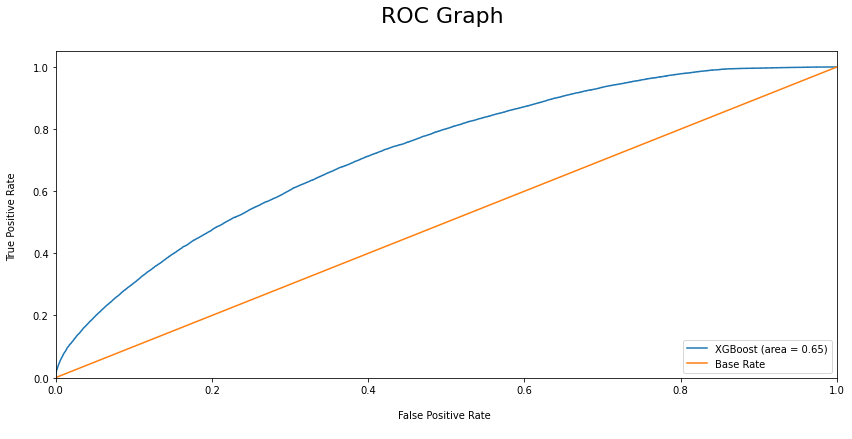

In [25]:
y_pred = xgb_classifier.predict(X_test)
preds = xgb_classifier.predict_proba(X_test)
from sklearn.metrics import auc, roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])
plt.figure(figsize=(14, 6))

# Plot RF ROC
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.ylabel('True Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()


In [26]:
threshold=0.5
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("xgboost_testset",'\n',
      "recall:",recall_score(y_test, predictions),'\n',
      "precision:",precision_score(y_test, predictions),'\n',
      "f1score:",f1_score(y_test, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

xgboost_testset 
 recall: 0.6224118053954346 
 precision: 0.18295559290787833 
 f1score: 0.28278701404821016 
 tn:130648, fp:60275, fn:8188, tp:13497 



In [27]:
joblib.dump(xgb_classifier, 'fe_data_v2/sale_data/xgb_accepted_flg_s.pkl')

['fe_data_v2/sale_data/xgb_accepted_flg_s.pkl']

In [28]:
x = test.drop(columns=class_column)
y = test[class_column]

In [29]:
mymodel = joblib.load('fe_data_v2/sale_data/xgb_accepted_flg_s.pkl')

In [30]:
preds = mymodel.predict_proba(x)

In [31]:
threshold=0.5
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
print("xgboost_test_unseen",'\n',
      "recall:",recall_score(y, predictions),'\n',
      "precision:",precision_score(y, predictions),'\n',
      "f1score:",f1_score(y, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

xgboost_test_unseen 
 recall: 0.47359610409374525 
 precision: 0.1283007977572097 
 f1score: 0.2019042057969604 
 tn:88635, fp:42287, fn:6918, tp:6224 



In [32]:
threshold=0.55
predictions = (preds[:,1] >= threshold).astype('int')
tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
print("xgboost_test_unseen",'\n',
      "recall:",recall_score(y, predictions),'\n',
      "precision:",precision_score(y, predictions),'\n',
      "f1score:",f1_score(y, predictions),'\n',
      'tn:{}, fp:{}, fn:{}, tp:{}'.format(tn, fp, fn, tp),'\n')

xgboost_test_unseen 
 recall: 0.3596865012935626 
 precision: 0.13709396751740138 
 f1score: 0.19852169165511738 
 tn:101169, fp:29753, fn:8415, tp:4727 



In [33]:
# print(classification_report(y_test, predictions))

In [34]:
#get vip info
vip = xgb_classifier.steps[1][1].feature_importances_

#create df with vip info
feature_importances_info = pd.DataFrame({'feat_names':list(xgb_classifier.steps[0][1].transformers_[0][1].get_feature_names())+num_list, 'vip': vip})

#get sign and magnitude information
feature_importances_info = feature_importances_info.assign(feature_importances_mag = abs(feature_importances_info['vip']),
                             feature_importances_sign = np.sign(feature_importances_info['vip']))
feature_importances_info = feature_importances_info.set_index('feat_names').sort_values(by='feature_importances_mag', ascending=False)
feature_importances_info.head(10)

,vip,feature_importances_mag,feature_importances_sign
feat_names,,,
x3_Unknown,0.10,0.10,1.00
zipcode_accepted_prop,0.09,0.09,1.00
x1_SD,0.07,0.07,1.00
x1_MD,0.04,0.04,1.00
lines,0.02,0.02,1.00
x11_23,0.02,0.02,1.00
num_decline,0.02,0.02,1.00
x6_4 High School,0.02,0.02,1.00
x3_High-Tech,0.02,0.02,1.00


In [35]:
feature_importances_info.to_csv('fe_data_v2/sale_data/feature_importances_s.csv')

In [36]:
d = dict(zip(["x"+str(i) for i in range(len(cat_list))], cat_list))
d
# plot_importance(xgb_classifier)

{'x0': 'exp',
 'x1': 'product_type',
 'x2': 'pmake',
 'x3': 'technodoption_class',
 'x4': 'hh_income',
 'x5': 'age_class',
 'x6': 'hh_education',
 'x7': 'hh_composition',
 'x8': 'hh_tenure',
 'x9': 'urbanicity',
 'x10': 'day_of_week',
 'x11': 'time_of_day',
 'x12': 'sentiment'}

In [37]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


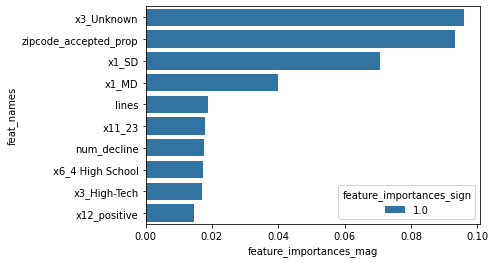

In [38]:
import seaborn as sns
sns.barplot(y=feature_importances_info.index[:10], x='feature_importances_mag', hue='feature_importances_sign', 
            data=feature_importances_info[:10], orient='h', dodge=False);

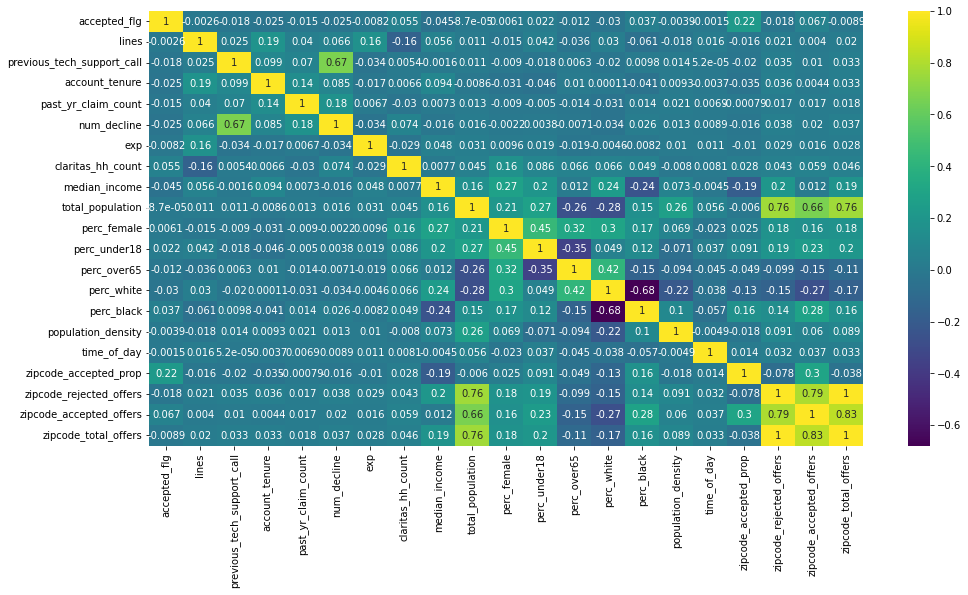

In [39]:
plt.figure(figsize = (16,8))
cor = train.corr()
sns.heatmap(cor, annot = True, cmap = "viridis")
plt.show()